In [1]:
import glob
import pandas as pd
from src.utils import map_category
import numpy as np
from datasets import load_from_disk


In [2]:
stream_data = load_from_disk("data/processed/stream_data")


In [3]:
stream_data.set_format(type="pandas")
train_df = stream_data["train"][:]
valid_df = stream_data["validation"][:]


In [4]:
X_train, y_train = train_df["text"], train_df["label"]
X_valid, y_valid = valid_df["text"], valid_df["label"]
labels = stream_data["train"].features["label"].names


In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
X_train_embed = model.encode(X_train, show_progress_bar=True)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/279 [00:00<?, ?it/s]

In [6]:
X_valid_embed = model.encode(X_valid, show_progress_bar=True)


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [7]:
X_train_embed.shape, X_valid_embed.shape

((8914, 384), (1114, 384))

In [8]:
from sklearn.metrics import f1_score
from sklearn.utils.extmath import density
from time import time

def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train_embed, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(X_valid_embed)
    test_time = time() - t0
    print(f"inference time:  {test_time:.3}s")

    weighted_f1 = f1_score(y_valid, pred, average="weighted")
    print(f"Weighted F1 score:    {weighted_f1:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()
    
    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, weighted_f1, train_time, test_time


In [9]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

results_embed = []
for clf, name in (
    (LogisticRegression(class_weight="balanced"), "Logistic Regression"),
    (RidgeClassifier(class_weight="balanced"), "Ridge Classifier"),
    (KNeighborsClassifier(), "kNN"),
    (XGBClassifier(), "XGBoost"),
    (LinearSVC(class_weight="balanced"), "Linear SVC"),
    (SGDClassifier(class_weight="balanced"), "SGD Classifier"),
    (NearestCentroid(), "NearestCentroid"),
):
    print("=" * 80)
    print(name)
    results_embed.append(benchmark(clf, name))


Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(class_weight='balanced')
train time: 6.81s
inference time:  0.00138s
Weighted F1 score:    0.789
dimensionality: 384
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(class_weight='balanced')
train time: 0.0988s
inference time:  0.0276s
Weighted F1 score:    0.769
dimensionality: 384
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier()
train time: 0.00204s
inference time:  0.164s
Weighted F1 score:    0.81

XGBoost
________________________________________________________________________________
Training: 
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_

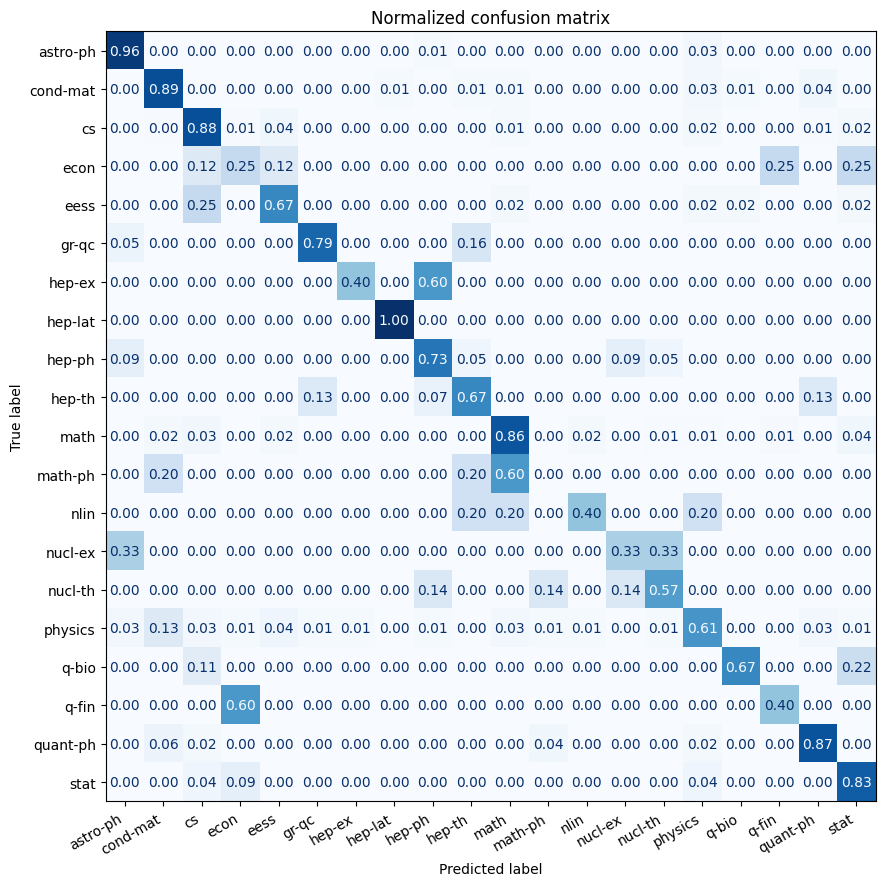

In [10]:
from src.utils import plot_confusion_matrix
from sklearn.svm import LinearSVC

svm_clf = LinearSVC(class_weight="balanced", random_state=42)
svm_clf.fit(X_train_embed, y_train)
y_preds = svm_clf.predict(X_valid_embed)

plot_confusion_matrix(y_preds, y_valid, labels)


In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_preds, target_names=labels))


              precision    recall  f1-score   support

    astro-ph       0.91      0.96      0.93        70
    cond-mat       0.80      0.89      0.84        79
          cs       0.95      0.88      0.91       474
        econ       0.18      0.25      0.21         8
        eess       0.56      0.67      0.61        48
       gr-qc       0.83      0.79      0.81        19
      hep-ex       0.67      0.40      0.50         5
     hep-lat       0.75      1.00      0.86         3
      hep-ph       0.70      0.73      0.71        22
      hep-th       0.59      0.67      0.62        15
        math       0.92      0.86      0.89       191
     math-ph       0.00      0.00      0.00         5
        nlin       0.29      0.40      0.33         5
     nucl-ex       0.25      0.33      0.29         3
     nucl-th       0.50      0.57      0.53         7
     physics       0.68      0.61      0.64        71
       q-bio       0.67      0.67      0.67         9
       q-fin       0.29    